In [1]:
%matplotlib notebook

import numpy as np
import json
import math
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from numpy.random import seed 
seed(2)
tf.random.set_seed(9)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU,Dense, Dropout, Flatten, Input, BatchNormalization, Reshape, UpSampling1D, Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras import regularizers

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,Binarizer

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score,f1_score

In [ ]:
fp_list = ['maccs']

class Data():
    
    def __init__(self, fp, pos_neg):
        
        self.fp = fp
        self.pos_neg = pos_neg
        
        if self.pos_neg == 'pos':
            self.load_pos_data()
            self.shuffle()
            
        elif self.pos_neg == 'neg':
            self.load_neg_data()
            self.shuffle()
    

    def load_pos_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        positive_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [1,0]]
        self.y = np.array([temp['y'][i] for i in positive_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in positive_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(positive_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def load_neg_data(self):
        with open('{}.json'.format(self.fp), 'r') as file:
            temp = json.load(file)
        negative_index = [i for i in range(len(temp['y'])) if temp['y'][i] == [0,1]]
        self.y = np.array([temp['y'][i] for i in negative_index])
        self.x = np.array([self.convert(temp['x'][i]) for i in negative_index])
        self.x = self.x.reshape(self.x.shape[0], self.x.shape[1],1)
        self.z = self.x.reshape(self.x.shape[0], self.x.shape[1])
        self.m = len(negative_index)
        self.n = self.x.shape[1]
        print('Shape x: {}'.format(self.x.shape))
        print('Shape y: {}'.format(self.y.shape))
    
    def shuffle(self):
        temp_x = np.zeros(self.x.shape)
        index = list(range(self.m))
        np.random.shuffle(index)
        for x in range(self.m):
            value = int(index[int(x)])
            temp_x[x,:] = self.x[value,:]
        self.x = temp_x
                                  
    def convert(self, string, as_array=True):
        letter_list = list('abcdef')
        jump = 1
        fp = []
        code = [0]*len(list(string))*4
        for index in range(len(list(string))):
            index += jump
            value = string[index].lower()
            if value in letter_list:
                value = letter_list.index(value) + 10
            index = (index-jump)*4
            value = int(value)
            code[index] = 1*value%2
            code[index+1] = 1*math.floor(value/2)%2
            code[index+2] = 1*math.floor(value/4)%2
            code[index+3] = 1*math.floor(value/8)%2
            jump *= -1
        if as_array == True:
            code = np.array(code)
        return code

In [3]:
pos_data=Data(fp='maccs', pos_neg='pos')
neg_data=Data(fp='maccs', pos_neg='neg')

Shape x: (7201, 168, 1)
Shape y: (7201, 2)
Shape x: (10000, 168, 1)
Shape y: (10000, 2)


In [4]:
batch_size=256
fingerprint_dim=168

#get real compounds
index = np.random.choice(range(pos_data.m), size=(batch_size), replace=False)
train_x_real = pos_data.x[index]
train_y_real = np.zeros([batch_size,2])
train_y_real[:,0] = 1
#d_loss_real = d.train_on_batch(train_x_real,train_y_real)
                
#get fake compounds
input_value = np.random.randint(0,2,size=[batch_size, fingerprint_dim])
train_x_fake = input_value.reshape((input_value.shape[0], input_value.shape[1], 1))
train_y_fake = np.zeros([batch_size,2])
train_y_fake[:,1] = 1
#d_loss_fake=d.train_on_batch(train_x_fake,train_y_fake)
        
#get decoys
index1 = np.random.choice(range(neg_data.m), size=(batch_size), replace=False)
train_x_decoy = neg_data.x[index1]
train_y_decoy = np.zeros([batch_size,2])
train_y_decoy[:,1] = 1
#d_loss_decoy = d.train_on_batch(train_x_real,train_y_real)
       
# d_loss = d_loss_real + d_loss_decoy
# loss_d_epoch.append(d_loss[0])
X = np.concatenate((train_x_real, train_x_decoy))
y = np.zeros([2*batch_size,2])
y[0:(batch_size),0] = 1
y[(batch_size):,1] = 1

In [6]:
epochs=1

model = Sequential()
model.add(Conv1D(8, kernel_size=3,
                 strides=1,
                 activation='relu',
                 padding='valid',
                 input_shape=[fingerprint_dim,1],
                 kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(16, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))

model.add(Conv1D(16, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv1D(32, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))

model.add(Conv1D(32, kernel_size=3, activation= 'relu', strides=1, padding='same'))
model.add(Conv1D(32, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Conv1D(32, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))

model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same'))
model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
#model.add(Conv1D(64, kernel_size=3, activation= 'relu', strides=1, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='valid'))
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0002),
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 166, 8)            32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 166, 16)           400       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 16)            0         
_________________________________________________________________
dropout (Dropout)            (None, 83, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 83, 16)            784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 83, 32)            1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 41, 32)            0

In [7]:
model.fit(X, y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X, y))

2/2 [==============================] - 0s 228ms/step - loss: 8.2308 - accuracy: 0.5137 - val_loss: 8.1719 - val_accuracy: 0.5586


In [8]:
cv = StratifiedKFold(n_splits=10)

In [9]:
df_y = pd.DataFrame(y)

In [10]:
y_new = df_y.iloc[:,0]

In [12]:
mean_fpr = np.linspace(0, 1, 100)
tprs=[]
tprs_all=[]
fprs=[]
aucs=[]
accs=[]
f1s=[]
for train,test in cv.split(X,y_new):
    model.fit(X[train],y[train],
             batch_size=batch_size,
             epochs=50,
             verbose=1,
             validation_data=(X[test],y[test]))
    pred_prob = model.predict_proba(X[test])[:,0]
    pred = model.predict(X[test])[:,0]
    y_pred = np.round(pred)
    print(y_pred)
    print(pred_prob)
    fpr, tpr, thresholds = roc_curve(y_new[test],pred_prob)
    roc_auc = auc(fpr,tpr)
    fprs.append(fpr)
    tprs.append(tpr)
    aucs.append(roc_auc)
    
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs_all.append(interp_tpr)
    
    acc = accuracy_score(y_new[test], y_pred)
    f1 = f1_score(y_new[test], y_pred)
    accs.append(acc)
    f1s.append(f1)
    
    

Epoch 1/50
2/2 [==============================] - 0s 179ms/step - loss: 8.1536 - accuracy: 0.5261 - val_loss: 8.0940 - val_accuracy: 0.5000
Epoch 2/50
2/2 [==============================] - 0s 29ms/step - loss: 8.0760 - accuracy: 0.5543 - val_loss: 8.0166 - val_accuracy: 0.5192
Epoch 3/50
2/2 [==============================] - 0s 27ms/step - loss: 7.9991 - accuracy: 0.5283 - val_loss: 7.9398 - val_accuracy: 0.4808
Epoch 4/50
2/2 [==============================] - 0s 27ms/step - loss: 7.9218 - accuracy: 0.5196 - val_loss: 7.8637 - val_accuracy: 0.5192
Epoch 5/50
2/2 [==============================] - 0s 26ms/step - loss: 7.8457 - accuracy: 0.5130 - val_loss: 7.7881 - val_accuracy: 0.5385
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: 7.7712 - accuracy: 0.4935 - val_loss: 7.7132 - val_accuracy: 0.5962
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 7.6961 - accuracy: 0.5261 - val_loss: 7.6390 - val_accuracy: 0.5962
Epoch 8/50
2/2 [==========

2/2 [==============================] - 0s 24ms/step - loss: 4.9970 - accuracy: 0.5739 - val_loss: 4.9619 - val_accuracy: 0.5000
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 4.9507 - accuracy: 0.5326 - val_loss: 4.9155 - val_accuracy: 0.5000
Epoch 4/50
2/2 [==============================] - 0s 23ms/step - loss: 4.9043 - accuracy: 0.5348 - val_loss: 4.8695 - val_accuracy: 0.5000
Epoch 5/50
2/2 [==============================] - 0s 27ms/step - loss: 4.8585 - accuracy: 0.5239 - val_loss: 4.8240 - val_accuracy: 0.5000
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 4.8126 - accuracy: 0.5609 - val_loss: 4.7790 - val_accuracy: 0.5000
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 4.7682 - accuracy: 0.5522 - val_loss: 4.7344 - val_accuracy: 0.5000
Epoch 8/50
2/2 [==============================] - 0s 29ms/step - loss: 4.7238 - accuracy: 0.5370 - val_loss: 4.6903 - val_accuracy: 0.5000
Epoch 9/50
2/2 [======================

2/2 [==============================] - 0s 23ms/step - loss: 3.0844 - accuracy: 0.5163 - val_loss: 3.0632 - val_accuracy: 0.5098
Epoch 6/50
2/2 [==============================] - 0s 24ms/step - loss: 3.0572 - accuracy: 0.5401 - val_loss: 3.0366 - val_accuracy: 0.5098
Epoch 7/50
2/2 [==============================] - 0s 24ms/step - loss: 3.0311 - accuracy: 0.5163 - val_loss: 3.0104 - val_accuracy: 0.5098
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 3.0047 - accuracy: 0.5618 - val_loss: 2.9844 - val_accuracy: 0.5098
Epoch 9/50
2/2 [==============================] - 0s 25ms/step - loss: 2.9790 - accuracy: 0.5401 - val_loss: 2.9587 - val_accuracy: 0.5098
Epoch 10/50
2/2 [==============================] - 0s 23ms/step - loss: 2.9532 - accuracy: 0.5380 - val_loss: 2.9332 - val_accuracy: 0.5098
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 2.9273 - accuracy: 0.6009 - val_loss: 2.9081 - val_accuracy: 0.5098
Epoch 12/50
2/2 [===================

2/2 [==============================] - 0s 26ms/step - loss: 2.0003 - accuracy: 0.5987 - val_loss: 1.9891 - val_accuracy: 0.5098
Epoch 9/50
2/2 [==============================] - 0s 27ms/step - loss: 1.9857 - accuracy: 0.5640 - val_loss: 1.9743 - val_accuracy: 0.5098
Epoch 10/50
2/2 [==============================] - 0s 27ms/step - loss: 1.9707 - accuracy: 0.5813 - val_loss: 1.9596 - val_accuracy: 0.5098
Epoch 11/50
2/2 [==============================] - 0s 24ms/step - loss: 1.9561 - accuracy: 0.5770 - val_loss: 1.9451 - val_accuracy: 0.5098
Epoch 12/50
2/2 [==============================] - 0s 24ms/step - loss: 1.9415 - accuracy: 0.5987 - val_loss: 1.9307 - val_accuracy: 0.5098
Epoch 13/50
2/2 [==============================] - 0s 23ms/step - loss: 1.9272 - accuracy: 0.5965 - val_loss: 1.9165 - val_accuracy: 0.5098
Epoch 14/50
2/2 [==============================] - 0s 27ms/step - loss: 1.9130 - accuracy: 0.5705 - val_loss: 1.9025 - val_accuracy: 0.5098
Epoch 15/50
2/2 [================

2/2 [==============================] - 0s 26ms/step - loss: 1.4008 - accuracy: 0.5011 - val_loss: 1.3945 - val_accuracy: 0.4902
Epoch 12/50
2/2 [==============================] - 0s 24ms/step - loss: 1.3926 - accuracy: 0.5011 - val_loss: 1.3864 - val_accuracy: 0.4902
Epoch 13/50
2/2 [==============================] - 0s 25ms/step - loss: 1.3845 - accuracy: 0.5011 - val_loss: 1.3784 - val_accuracy: 0.4902
Epoch 14/50
2/2 [==============================] - 0s 26ms/step - loss: 1.3766 - accuracy: 0.5011 - val_loss: 1.3705 - val_accuracy: 0.4902
Epoch 15/50
2/2 [==============================] - 0s 24ms/step - loss: 1.3687 - accuracy: 0.5011 - val_loss: 1.3626 - val_accuracy: 0.4902
Epoch 16/50
2/2 [==============================] - 0s 27ms/step - loss: 1.3608 - accuracy: 0.5011 - val_loss: 1.3549 - val_accuracy: 0.4902
Epoch 17/50
2/2 [==============================] - 0s 24ms/step - loss: 1.3532 - accuracy: 0.5011 - val_loss: 1.3473 - val_accuracy: 0.4902
Epoch 18/50
2/2 [===============

2/2 [==============================] - 0s 24ms/step - loss: 1.0771 - accuracy: 0.5011 - val_loss: 1.0738 - val_accuracy: 0.4902
Epoch 15/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0727 - accuracy: 0.5011 - val_loss: 1.0695 - val_accuracy: 0.4902
Epoch 16/50
2/2 [==============================] - 0s 25ms/step - loss: 1.0684 - accuracy: 0.5011 - val_loss: 1.0652 - val_accuracy: 0.4902
Epoch 17/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0642 - accuracy: 0.5011 - val_loss: 1.0610 - val_accuracy: 0.4902
Epoch 18/50
2/2 [==============================] - 0s 28ms/step - loss: 1.0600 - accuracy: 0.5011 - val_loss: 1.0568 - val_accuracy: 0.4902
Epoch 19/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0558 - accuracy: 0.5011 - val_loss: 1.0527 - val_accuracy: 0.4902
Epoch 20/50
2/2 [==============================] - 0s 24ms/step - loss: 1.0517 - accuracy: 0.5011 - val_loss: 1.0487 - val_accuracy: 0.4902
Epoch 21/50
2/2 [===============

2/2 [==============================] - 0s 25ms/step - loss: 0.9058 - accuracy: 0.4989 - val_loss: 0.9040 - val_accuracy: 0.5098
Epoch 18/50
2/2 [==============================] - 0s 27ms/step - loss: 0.9035 - accuracy: 0.4989 - val_loss: 0.9017 - val_accuracy: 0.5098
Epoch 19/50
2/2 [==============================] - 0s 27ms/step - loss: 0.9013 - accuracy: 0.4989 - val_loss: 0.8995 - val_accuracy: 0.5098
Epoch 20/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8990 - accuracy: 0.4989 - val_loss: 0.8973 - val_accuracy: 0.5098
Epoch 21/50
2/2 [==============================] - 0s 26ms/step - loss: 0.8968 - accuracy: 0.4989 - val_loss: 0.8951 - val_accuracy: 0.5098
Epoch 22/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8946 - accuracy: 0.4989 - val_loss: 0.8929 - val_accuracy: 0.5098
Epoch 23/50
2/2 [==============================] - 0s 26ms/step - loss: 0.8925 - accuracy: 0.4989 - val_loss: 0.8908 - val_accuracy: 0.5098
Epoch 24/50
2/2 [===============

2/2 [==============================] - 0s 25ms/step - loss: 0.8154 - accuracy: 0.4989 - val_loss: 0.8145 - val_accuracy: 0.5098
Epoch 21/50
2/2 [==============================] - 0s 24ms/step - loss: 0.8142 - accuracy: 0.4989 - val_loss: 0.8133 - val_accuracy: 0.5098
Epoch 22/50
2/2 [==============================] - 0s 23ms/step - loss: 0.8130 - accuracy: 0.4989 - val_loss: 0.8121 - val_accuracy: 0.5098
Epoch 23/50
2/2 [==============================] - 0s 29ms/step - loss: 0.8118 - accuracy: 0.4989 - val_loss: 0.8109 - val_accuracy: 0.5098
Epoch 24/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8106 - accuracy: 0.4989 - val_loss: 0.8097 - val_accuracy: 0.5098
Epoch 25/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8095 - accuracy: 0.4989 - val_loss: 0.8086 - val_accuracy: 0.5098
Epoch 26/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8083 - accuracy: 0.4989 - val_loss: 0.8074 - val_accuracy: 0.5098
Epoch 27/50
2/2 [===============

2/2 [==============================] - 0s 24ms/step - loss: 0.7668 - accuracy: 0.5011 - val_loss: 0.7663 - val_accuracy: 0.4902
Epoch 24/50
2/2 [==============================] - 0s 24ms/step - loss: 0.7661 - accuracy: 0.5011 - val_loss: 0.7656 - val_accuracy: 0.4902
Epoch 25/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7655 - accuracy: 0.5011 - val_loss: 0.7650 - val_accuracy: 0.4902
Epoch 26/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7648 - accuracy: 0.5011 - val_loss: 0.7643 - val_accuracy: 0.4902
Epoch 27/50
2/2 [==============================] - 0s 26ms/step - loss: 0.7642 - accuracy: 0.5011 - val_loss: 0.7637 - val_accuracy: 0.4902
Epoch 28/50
2/2 [==============================] - 0s 23ms/step - loss: 0.7635 - accuracy: 0.5011 - val_loss: 0.7631 - val_accuracy: 0.4902
Epoch 29/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7629 - accuracy: 0.5011 - val_loss: 0.7624 - val_accuracy: 0.4902
Epoch 30/50
2/2 [===============

2/2 [==============================] - 0s 25ms/step - loss: 0.7396 - accuracy: 0.5011 - val_loss: 0.7393 - val_accuracy: 0.4902
Epoch 27/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7392 - accuracy: 0.5011 - val_loss: 0.7389 - val_accuracy: 0.4902
Epoch 28/50
2/2 [==============================] - 0s 28ms/step - loss: 0.7388 - accuracy: 0.5011 - val_loss: 0.7385 - val_accuracy: 0.4902
Epoch 29/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7384 - accuracy: 0.5011 - val_loss: 0.7382 - val_accuracy: 0.4902
Epoch 30/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7381 - accuracy: 0.5011 - val_loss: 0.7378 - val_accuracy: 0.4902
Epoch 31/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7377 - accuracy: 0.5011 - val_loss: 0.7374 - val_accuracy: 0.4902
Epoch 32/50
2/2 [==============================] - 0s 26ms/step - loss: 0.7373 - accuracy: 0.5011 - val_loss: 0.7370 - val_accuracy: 0.4902
Epoch 33/50
2/2 [===============

<IPython.core.display.Javascript object>


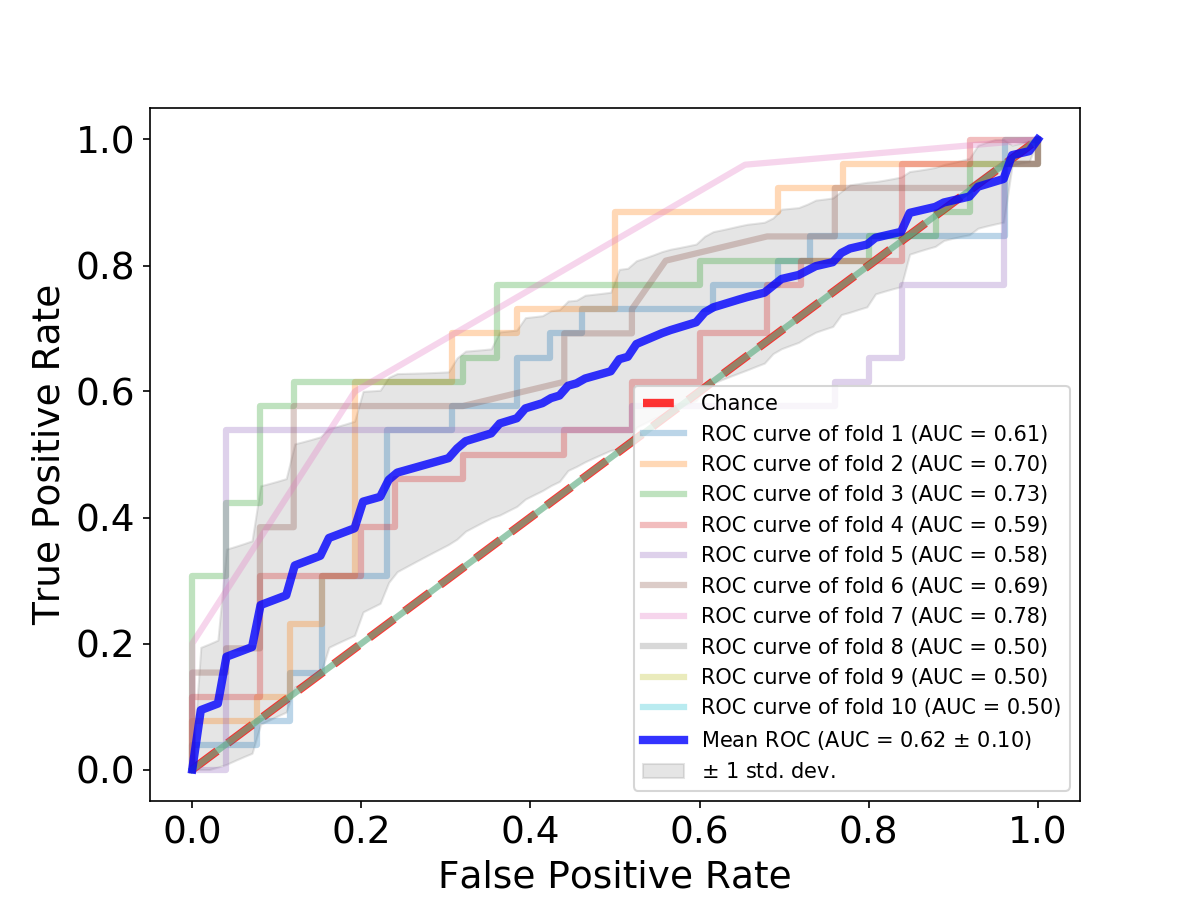

In [13]:
fig, ax = plt.subplots(figsize = (8,6))

ax.plot([0, 1], [0, 1], linestyle='--', color='r',
        label='Chance', alpha=.8, linewidth = 4)

for j in range(10):
    ax.plot(fprs[j], tprs[j], label='ROC curve of fold {0} (AUC = {1:0.2f})'.format(j+1, aucs[j]), alpha=0.3, linewidth = 3)

mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean(tprs_all, axis=0)
mean_tpr[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr)
std_auc_svm = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_svm, std_auc_svm),
        alpha=.8, linewidth = 4)

std_tpr = np.std(tprs_all, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])

ax.legend(loc="lower right")

plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", prop={"size":10})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('maccs_D_vggnet.pdf',dpi=600)
plt.show()